<a href="https://colab.research.google.com/github/szsctt/learn_torch/blob/main/learn_torch_2_datsets_and_dataloaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Datasets and Data Loaders

From the [torch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

Since code for processing data can be messy and hard to maintain, pytorch recommends that users decouple dataset code from model training code.

The classes `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` allow us to use pre-loaded datsets as well as user-provided data.

PyTorch domain libraries contain a number of datasets that subclass `torch.utils.data.Dataset` and implment functions specific to the particular data.  They can be used to benchmark user datasets.

- [image datasets](https://pytorch.org/vision/stable/datasets.html)
- [text datasets](https://pytorch.org/text/stable/datasets.html)
- [audio datasets](https://pytorch.org/audio/stable/datasets.html)

### Loading a dataset

The TorchVision library contains the FashionMNIST dataset, which consists of 60,000 training examples and 10,000 test examples of 28x28 greyscale images and associated labels.

Here we load the dataset making use of the parameters:

 - `root` is where the test/train data is stored
 - `train` specifies if the dataset is traning or test
 - `download=True` downloads the data if it's not available at `root`
 - `transform` and `target_transform` specify the feature and label transformations


In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### Indexing and iterating the dataset

We can index datasets manually like a list `training_data[index]`.  Here, we use `matplotlib` to visualize some samples.



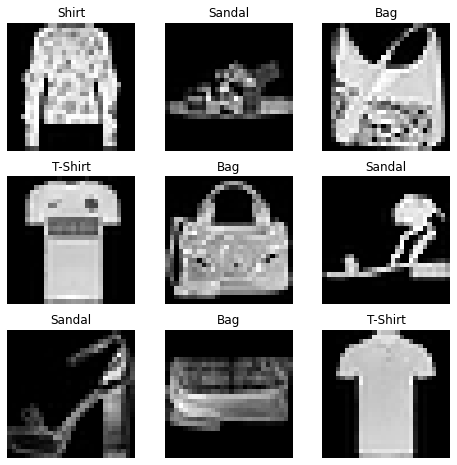

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")

plt.show()

### Creating your own dataset

A custom dataset class must implement three methods: `__init__`, `__len__` and `__getitem__`.

In the following example, the FashionMNIST images are stored in a directory, `img_dir`, and their labels are stored seperately in a CSV file called `annotations_file`.

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):


    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        """
        Run once when instantiating the Dataset.
        """
        # load image labels
        self.img_labels = pd.read_csv(annotations_file)

        # store image directory
        self.img_dir = img_dir

        # use transforms
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """
        Return the number of examples in the dataset
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Load and return sample at idx from the dataset.

        Do this by identifying file on disk, 
        reading the image and converting to a tensor using `read_image`,
        retrieving the corresponding label from the csv data in `self.img_labels`,
        calling the transform function on them, and returning the tensor and label
        as a tuple.
        """
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


### Preparing data for traing with a DataLoader

The `Dataset` class retrieves training examples one at a time.  Typically, we process data in minibatches, reshuffle the data at every iteration to reduce overfitting, and use `multiprocess` to speed up data retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an easy API.

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)



#### Iterating through a DataLoader


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


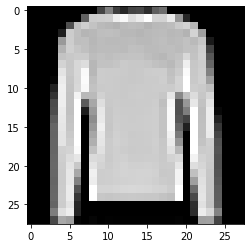

Label: 2


In [5]:
# get a minibatch of examples and their labels
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# show one example from the batch
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")



### Transforms

Often, to use data we first need to transform it to a form easily used by PyTorch.  We use **transforms** to do this.

All TorchVision have two parameters - `transform`, which modifies the features of the training examples, and `target_transform`, which modify the labels of the training examples.

The [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) offers several commonly-used transforms.

The FasionMNIST images are in PIL image format, but for training we need the examples as normalized tensors, and the labels as one-hot encoded tensors.

Make these transformations using `ToTensor()` and `Lambda()`.

In [7]:
import torch
from torchvision import datasets
from torchvision.transforms import Lambda, ToTensor

ds = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    # ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. 
    # and scales the image’s pixel intensity values in the range [0., 1.]
    transform = ToTensor(),
    #  first creates a zero tensor of size 10
    # then calls scatter_ which assigns a value=1 on the index 
    # given by the label y
    target_transform = Lambda(
        lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, 
                                                              torch.tensor(y),
                                                              value = 1)
    )
)
